In [1]:
## Wonder take home OA
## Author: Huikun Zhang
## Last modified on 1/15/2022


## Question 1: Order Forecasting

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
#load data

order = pd.read_csv("./a1/orders.csv")
# engineer date to week day and week
order['Date'] = pd.to_datetime(order['Date'])
order['DoW'] = order['Date'].dt.day_name()
order['Week'] = order['Date'].dt.week

# Feature engineering based on Exploratory Data Analysis -- see below
order['outlier'] = np.where(order['Days Of launch'].isin([20,90]), 1, 0)
order['workday'] = np.where(order['DoW'].isin(['Saturday', 'Sunday']), 0, 1)
order['stage'] = np.where(order['Days Of launch'] > 70, 1, 0)
order['daytofit'] = order['Days Of launch'] + 1

X = order[['daytofit', 'stage', 'outlier', 'workday']]
y = order['Number of Orders']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=2022, stratify=order['stage'])
# fit model
reg = LinearRegression().fit(X_train, y_train )
print(reg.score(X_train, y_train))
print(reg.coef_)

# model evaluation

print("train set")
y_pred = reg.predict(X_train)
print(metrics.mean_absolute_error(y_pred, y_train))
print(metrics.mean_squared_error(y_pred, y_train))
print(np.sqrt(metrics.mean_squared_error(y_pred, y_train)))

print("test set")
y_pred2 = reg.predict(X_test)
print(metrics.mean_absolute_error(y_pred2, y_test))
print(metrics.mean_squared_error(y_pred2, y_test))
print(np.sqrt(metrics.mean_squared_error(y_pred2, y_test)))

"""
Performance on train and test set are close in terms of MAE and RMSE
Actually 100 observations and 4 variables, chance of overfitting is small

Above is suggested for problems that may have overfitting concerns while regularization methods are applied

Next, I'll fit model using all 100 observations and make the prediction for the next week starting from 2021-08-18
"""

print("all data model")
reg_all = LinearRegression().fit(X, y)
print(reg_all.score(X, y))
print(reg_all.coef_)

nextweek = pd.DataFrame({'Days Of launch': [101, 102, 103, 104, 105, 106, 107],
                         'stage': [1, 1, 1, 1, 1, 1, 1],
                        'outlier': [0, 0, 0, 0, 0, 0, 0],
                        'workday': [1, 1, 1, 0, 0, 1, 1]})
nextweek['daytofit'] = nextweek['Days Of launch'] + 1

nextweek['pred_orders'] = np.round(reg_all.predict(nextweek[['daytofit', 'stage', 'outlier', 'workday']]))
print(nextweek)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


0.9725830823952056
[ 0.3768652  28.49689061 26.18560134 -6.1459903 ]
train set
2.9069575412465705
16.425978913069915
4.052897594693198
test set
3.7399003630520937
26.513471226252285
5.149123345410584
all data model
0.9657592890687285
[ 0.3928302  27.30893127 27.31343961 -5.4269271 ]
   Days Of launch  stage  outlier  workday  daytofit  pred_orders
0             101      1        0        1       102         74.0
1             102      1        0        1       103         74.0
2             103      1        0        1       104         75.0
3             104      1        0        0       105         81.0
4             105      1        0        0       106         81.0
5             106      1        0        1       107         76.0
6             107      1        0        1       108         76.0


'\nTopic #2 - outliers\n\n2 obvious outliers observed -- outlier affect the performance of regression model\nday 90 and day 20 order.iloc[[20,90]] -- both at Sunday\n\nsee below - more outliers might be detected based on difference between two consecutive observation, suspitious observations might be worthy of discussion\nDay 78, 82, 76, 86\n\nDepending on assumptions, different approaches might be taken\n\nOption 1 (chosen): Given we might want to keep the continuity of observations (days of launch)\nOption 2: might be data defects during data construction/collection -- remove or use average of that week\n'

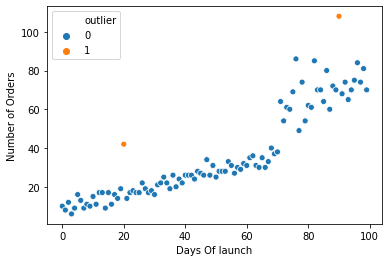

In [2]:
# lets take a look at the scatter plot
"""
plt.scatter(order['Days Of launch'], order['Number of Orders'], c="g", alpha=0.5)
plt.xlabel("Days of launch")
plt.ylabel("Number of Orders")
plt.show()

"""

sns.scatterplot(data=order, x="Days Of launch", y="Number of Orders", hue="outlier")

"""
Topic #1 - systematic change

observe linearly increasing pattern (especially from day 0 to day 70ish) of #orders as days since launch increase
order.iloc[65:75]
at day 71 - 2021-07-20, observe a jump, day difference is 64-38 = 26 --- this indicate a systemmatic change

Action - create an indicator for this in regression model

""" 

"""
Topic #2 - outliers

2 obvious outliers observed -- outlier affect the performance of regression model
day 90 and day 20 order.iloc[[20,90]] -- both at Sunday

see below - more outliers might be detected based on difference between two consecutive observation, suspitious observations might be worthy of discussion
Day 78, 82, 76, 86

Depending on assumptions, different approaches might be taken

Option 1 (chosen): Given we might want to keep the continuity of observations (days of launch)
Option 2: might be data defects during data construction/collection -- remove or use average of that week
"""


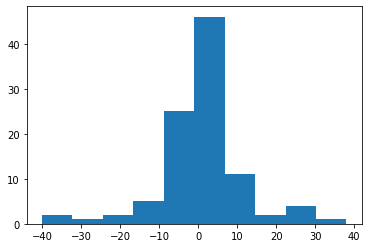

In [3]:
#lets deal with outliers first
#difference between two consecutive observation could serve as the metric to detect outlier

day_dis = order['Number of Orders'].diff()
plt.hist(day_dis[1:])
plt.show() 

#day_dis.sort_values(ascending=False).head(10)
#Given we only observe abnormal increase in orders, 

'\nFinding is different to the statement on hint\n\nData tells Saturday and Sunday often have more demands\n\n\n'

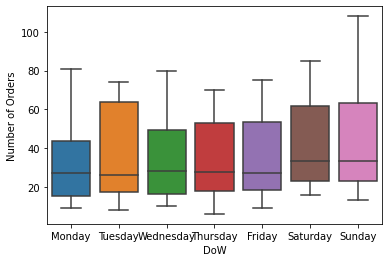

In [4]:
# lets take a look at boxplot by days of week

sns.boxplot(y='Number of Orders', x='DoW', 
                 data=order)

"""
Finding is different to the statement on hint

Data tells Saturday and Sunday often have more demands


"""

'\nafter removing 2 outliers\nwe still observe Saturday has more demands, Sunday is slightly above workdays\n'

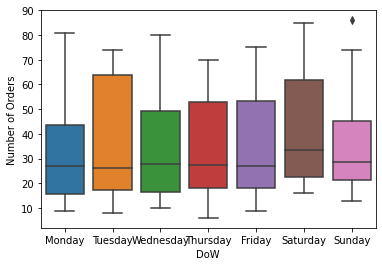

In [5]:
sns.boxplot(y='Number of Orders', x='DoW', 
                 data=order.drop([20,90]))

"""
after removing 2 outliers
we still observe Saturday has more demands, Sunday is slightly above workdays
"""

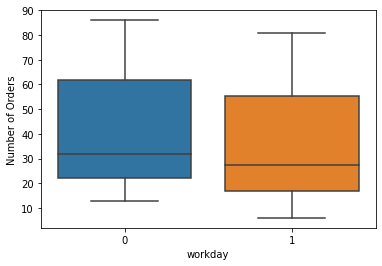

In [6]:
sns.boxplot(y='Number of Orders', x='workday', 
                 data=order.drop([20,90]))

# as expected